In [12]:
import yfinance as yf
import pandas as pd

# 下載NVDA的股票數據
nvda = yf.Ticker("NVDA")
nvda_history = nvda.history(period="5y")

# 保存數據到CSV文件
csv_path = "nvda_stock_data.csv"
nvda_history[['Close']].to_csv(csv_path, index=True, index_label='Date')

print(f"CSV文件已生成：{csv_path}")

CSV文件已生成：nvda_stock_data.csv


1198/1198 [==============================] - 20s 15ms/step - loss: 0.0013
x_test shape: (1198, 60, 1)
38/38 [==============================] - 1s 12ms/step


C:\Users\jk121\AppData\Local\Temp\ipykernel_25480\1921787988.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


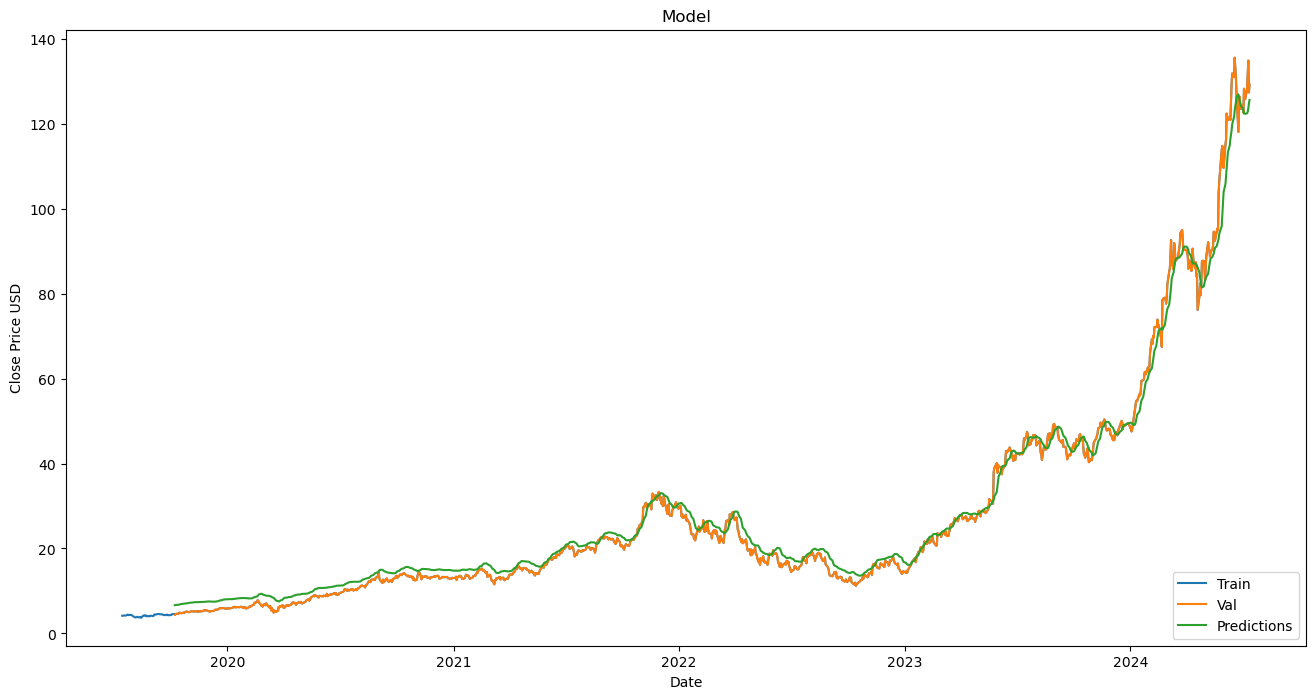

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 讀取數據
data = pd.read_csv('nvda_stock_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

# 數據預處理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 生成訓練和測試數據集
time_steps = 60
train_data = scaled_data

# 準備訓練數據
x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 構建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 編譯和訓練模型
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# 準備測試數據集
test_data = scaled_data
x_test = []
y_test = test_data[time_steps:]  # 確保 y_test 的索引對應 x_test

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i])

x_test = np.array(x_test)

# 檢查 x_test 的形狀
print(f"x_test shape: {x_test.shape}")

# 檢查 x_test 是否為空
if x_test.size == 0:
    print("x_test is empty, check the test_data length and indices.")
else:
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # 預測股價
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # 可視化結果
    train = data[:len(train_data)]
    valid = data[time_steps:]
    valid['Predictions'] = predictions

    # 現在繪製結果
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD')
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

1/1 [==============================] - 0s 26ms/step
未來預測的股價:
第 1 天: 134.26107788085938
第 2 天: 135.00149536132812
第 3 天: 135.8765106201172
第 4 天: 136.8303985595703
第 5 天: 137.82859802246094
第 6 天: 138.850341796875
第 7 天: 139.8830108642578
第 8 天: 140.91893005371094
第 9 天: 141.95347595214844
第 10 天: 142.98358154296875


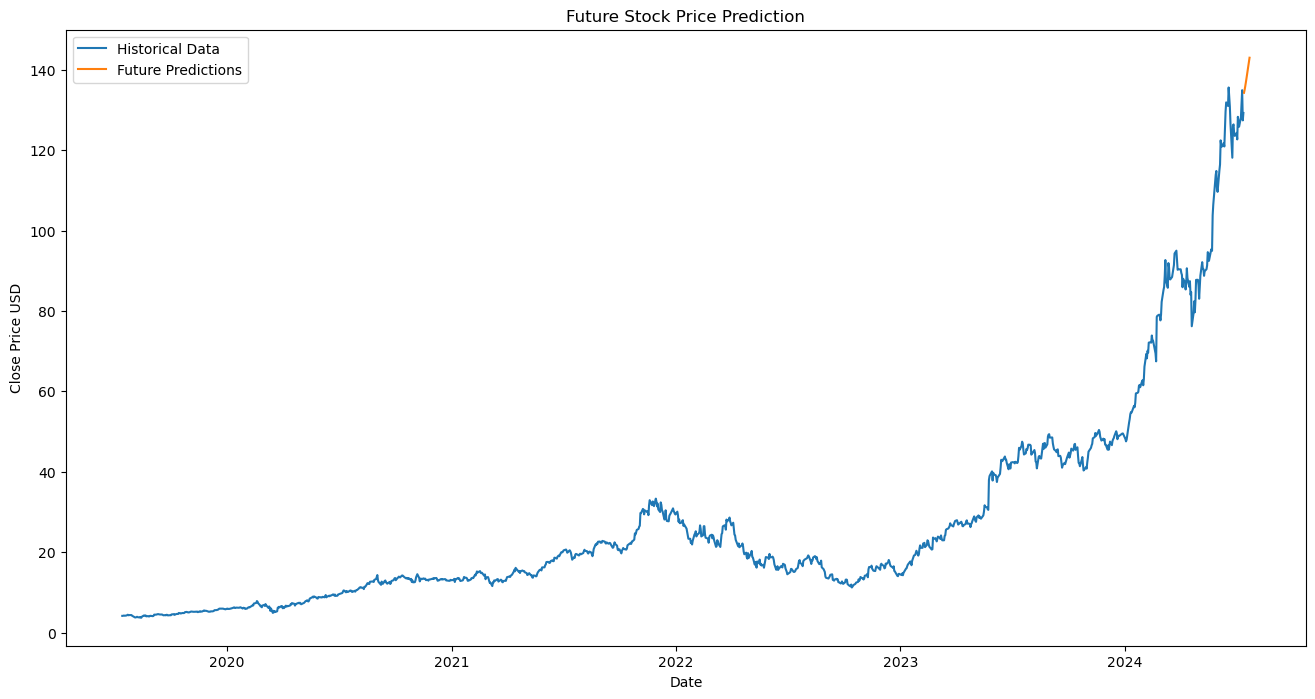

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 讀取數據
data = pd.read_csv('nvda_stock_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

# 數據預處理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 生成訓練數據集
time_steps = 60
train_data = scaled_data

# 準備訓練數據
x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 構建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 編譯和訓練模型
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# 預測未來的股價
def predict_future(model, data, scaler, time_steps, days_to_predict):
    future_predictions = []
    last_data = data[-time_steps:]
    
    for _ in range(days_to_predict):
        x_input = np.reshape(last_data, (1, time_steps, 1))
        next_price = model.predict(x_input)
        future_predictions.append(next_price[0, 0])
        last_data = np.append(last_data[1:], next_price)
        
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

# 設定要預測的天數
days_to_predict = 10
future_predictions = predict_future(model, scaled_data, scaler, time_steps, days_to_predict)

# 顯示預測結果
print("未來預測的股價:")
for i, price in enumerate(future_predictions, 1):
    print(f"第 {i} 天: {price[0]}")

# 繪製未來預測結果
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=days_to_predict)
future_data = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted Close'])

plt.figure(figsize=(16, 8))
plt.title('Future Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(data['Close'], label='Historical Data')
plt.plot(future_data['Predicted Close'], label='Future Predictions')
plt.legend()
plt.show()